# CUNEF MUCD 2021/2022  
## Machine Learning
## Análisis de Siniestralidad de Automóviles

### Autores:
- Andrés Mahía Morado
- Antonio Tello Gómez


In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer

warnings.filterwarnings('ignore')

from aux_func import evaluate_model
from aux_func import model_analysis, cargar_modelo
import lightgbm as lgb
import pickle


In [2]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from aux_func import model_analysis, cargar_modelo

In [3]:
#Cargamos pipeline preprocesado. Esto no funciona por cuestiones de incompatibilidad entre pickle y GridSearchCV. Funciona pero sin multithreading (n_jobs máximo es 1)
# por lo que generamos de nuevo el preprocessor

preprocessor = cargar_modelo('../models/preprocessor.pickle')

In [4]:
xtrain = pd.read_parquet("../data/xtrain.parquet")
ytrain = pd.read_parquet("../data/ytrain.parquet")['fatality']
xtest = pd.read_parquet("../data/xtest.parquet")
ytest = pd.read_parquet("../data/ytest.parquet")['fatality']

# Optimización de modelos

## LightGBM

Generamos un campo de parámetros cuyas combinaciones serán probadas mediante una búsqueda Grid, que irá descartando combinaciones de parámetros si determina que ha encontrado un "camino" que genere modelos más precisos.
Utilizamos el ROC-AUC score como métrica a optimizar, en vez del parámetro por defecto *precisión* ya que esta será muy alta de todas maneras al estar utilizando datos desbalanceados.

In [5]:
lightgbm = cargar_modelo("../models/LightGBM.pickle")

In [6]:
lightgbm = Pipeline(steps=[('preprocessor', preprocessor),
                            ('clasificador', lgb.LGBMClassifier())])

In [7]:
param_grid = { 
    'clasificador__is_unbalance': [True],
    'clasificador__max_depth': [-1],
    'clasificador__objective': ['binary'],
    'clasificador__learning_rate': [0.1, 0.05], 
    'clasificador__n_estimators' : [200, 300, 400], 
    'clasificador__importance_type' : ['split', 'gain'],
    'clasificador__num_leaves': [50, 100, 200]
    }

CV = GridSearchCV(lightgbm, param_grid, cv=3, n_jobs=8, scoring='roc_auc', verbose=1)

In [8]:
CV.fit(xtrain,ytrain)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['vehicle_age',
                                                                          'passenger_age',
                                                                          'vehicles_involved',
                                                                          'year']),
                                                 

In [14]:
with open('../models/LightGBM_optimizado.pickle', 'wb') as f:
    pickle.dump(CV, f)

In [23]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/LightGBM_optimizado.pickle', 'rb') as f:
    CV = pickle.load(f)

¿Qué parámetros del modelo son los más óptimos, dentro de los que hemos escogido?

Además, generamos las predicciones para los datos de validación o test.

In [24]:
print(CV.best_params_)
print(CV.best_score_)
ypred = CV.predict(xtest)
ypred_proba = CV.predict_proba(xtest)

{'clasificador__importance_type': 'split', 'clasificador__is_unbalance': True, 'clasificador__learning_rate': 0.05, 'clasificador__max_depth': -1, 'clasificador__n_estimators': 300, 'clasificador__num_leaves': 200, 'clasificador__objective': 'binary'}
0.8552825906023136


Evaluamos el modelo

In [25]:
evaluate_model(ytest, ypred, ypred_proba)

ROC-AUC score of the model: 0.8631091807671063
Accuracy of the model: 0.8031338143916124

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    799946
           1       0.06      0.75      0.10     12291

    accuracy                           0.80    812237
   macro avg       0.53      0.78      0.50    812237
weighted avg       0.98      0.80      0.88    812237


Confusion matrix: 
[[643103 156843]
 [  3059   9232]]



El modelo obtiene un recall del 80% y 74% para los valores 0 y 1 respectivamente.
Respecto al modelo obtenido previamente, la mejoría es notable ya que la pérdida de recall en la clase positiva se ve compensada por una ganancia equivalente en el recall de la clase negativa. Sin embargo, y recordando el desbalanceo presente en los datos, la pérdida de recall en la clase negativa supone un mayor número de observaciones en las que nuestro modelo se ha equivocado por lo que debemos minimizarla.

### Ajuste del umbral de predicción

Realizamos las predicciones del modelo con el umbral de predicción ajustado a la curva ROC.

In [13]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.484888, G-Mean=0.779
ROC-AUC score of the model: 0.8631091807671063
Accuracy of the model: 0.7910523652579234

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    799946
           1       0.05      0.77      0.10     12291

    accuracy                           0.79    812237
   macro avg       0.52      0.78      0.49    812237
weighted avg       0.98      0.79      0.87    812237


Confusion matrix: 
[[633097 166849]
 [  2866   9425]]



## Random Forest

Generamos el *param grid* para el modelo Random Forest y procedemos a entrenar el modelo con los datos de *train*

In [16]:
rf = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', RandomForestClassifier())])

### Parameter Tunning Optimization
param_grid = { 
    'clasificador__n_estimators': [200, 250, 500],
    'clasificador__max_features': ['sqrt', 'log2'],
    'clasificador__max_depth' : [4, 6, 8, None],
    'clasificador__criterion' :['gini'],
    'clasificador__class_weight':['balanced']}


CV = GridSearchCV(rf, param_grid, cv=3, n_jobs=8, scoring='roc_auc', verbose=1)

In [17]:
CV.fit(xtrain, ytrain)
print(CV.best_params_)
print(CV.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
{'clasificador__class_weight': 'balanced', 'clasificador__criterion': 'gini', 'clasificador__max_depth': None, 'clasificador__max_features': 'sqrt', 'clasificador__n_estimators': 500}
0.8348362450542549


In [18]:
with open('../models/RandomForest_optimizado.pickle', 'wb') as f:
    pickle.dump(CV, f)

In [19]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/RandomForest_optimizado.pickle', 'rb') as f:
    CV = pickle.load(f)

Obtenemos los parámetros mas precisos para el modelo y generamos las series de predicción *ypred* e *ypred_proba*

In [20]:
print(CV.best_params_)
print(CV.best_score_)
ypred = CV.predict(xtest)
ypred_proba = CV.predict_proba(xtest)

{'clasificador__class_weight': 'balanced', 'clasificador__criterion': 'gini', 'clasificador__max_depth': None, 'clasificador__max_features': 'sqrt', 'clasificador__n_estimators': 500}
0.8348362450542549


Evaluamos el modelo

In [21]:
evaluate_model(ytest, ypred, ypred_proba)

ROC-AUC score of the model: 0.8415931374224647
Accuracy of the model: 0.9849342002395852

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    799946
           1       0.54      0.03      0.05     12291

    accuracy                           0.98    812237
   macro avg       0.76      0.51      0.52    812237
weighted avg       0.98      0.98      0.98    812237


Confusion matrix: 
[[799654    292]
 [ 11945    346]]



### Ajuste del umbral de predicción

In [22]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.013782, G-Mean=0.765
ROC-AUC score of the model: 0.8415931374224647
Accuracy of the model: 0.7687177510997406

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    799946
           1       0.05      0.76      0.09     12291

    accuracy                           0.77    812237
   macro avg       0.52      0.76      0.48    812237
weighted avg       0.98      0.77      0.86    812237


Confusion matrix: 
[[615028 184918]
 [  2938   9353]]



# Conclusiones

El modelo seleccionado que, llegado el momento, mandaríamos a producción y sobre el cual vamos a realizar el análisis de explicabilidad e interpretabilidad es el modelo **LightGBM sin ajuste de threshold** 

ROC-AUC score of the model: 0.8631091807671063
Accuracy of the model: 0.8031338143916124

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    799946
           1       0.06      0.75      0.10     12291

    accuracy                           0.80    812237
   macro avg       0.53      0.78      0.50    812237
weighted avg       0.98      0.80      0.88    812237


Confusion matrix: 
[[643103 156843]
 [  3059   9232]]



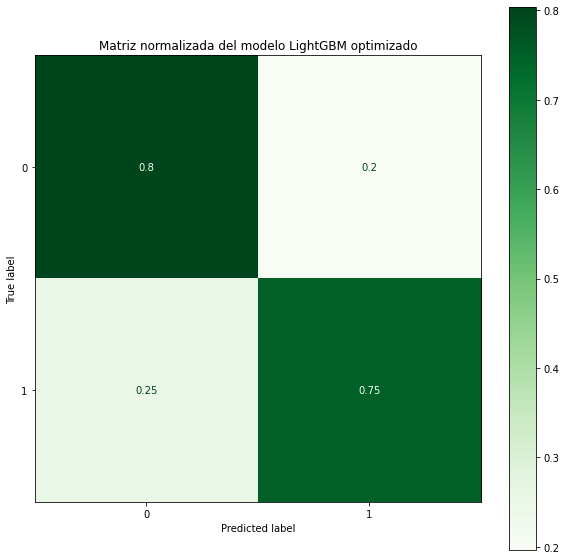

In [26]:
ypred = CV.predict(xtest)
ypred_proba = CV.predict_proba(xtest)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize='true',
                                                       ax=ax)
ax.set_title('Matriz normalizada del modelo LightGBM optimizado')

evaluate_model(ytest, ypred, ypred_proba)

El modelo consigue estimar el 75% de los casos positivos (accidentes mortales) manteniendo un 80% de recall en los casos negativos (accidentes no mortales), un balance que hemos considerado óptimo en comparación con el resto de modelos que hemos ejecutado a lo largo de este trabajo.

La principal razón por la que no ha sido necesario realizar un ajuste de threshold en este apartado del trabajo ha sido presumiblemente el uso del parámetro *scoring = 'roc_auc'* a la hora de generar los modelos, como ya hemos comentado previamente.